<a href="https://colab.research.google.com/github/lponcec94/PolyWorks/blob/main/semana_7/Semana_7_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objetivo 

El objetivo de este notebook es utilizar un *autoencoder* en el dataset de METABRIC sobre cáncer de mama. 

Revisaremos:
  
  1. EDA
  2. ¿Qué es Keras?
  3. Implementación Autoencoder 
  4. Modelo de Clasificación AdaBoost 

### Intro

In [159]:
import numpy as np 
import pandas as pd 
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

import warnings
warnings.simplefilter('ignore')

https://www.cbioportal.org/study/summary?id=brca_metabric

In [160]:
df = pd.read_csv('https://raw.githubusercontent.com/lponcec94/PolyWorks/main/semana_7/data/METABRIC_RNA_Mutation.csv')

In [161]:
df.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,hormone_therapy,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,...,gpr32_mut,kras_mut,nf2_mut,chek2_mut,ldlrap1_mut,clrn2_mut,acvrl1_mut,agtr2_mut,cdkn2a_mut,ctnna1_mut,magea8_mut,prr16_mut,dtwd2_mut,akt2_mut,braf_mut,foxo1_mut,nt5e_mut,ccnd3_mut,nr3c1_mut,prkg1_mut,tbl1xr1_mut,frmd3_mut,smad2_mut,sgcd_mut,spaca1_mut,rasgef1b_mut,hist1h2bc_mut,nr2f1_mut,klrg1_mut,mbl2_mut,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,1,Negative,1,ER-/HER2-,22.0,2.0,Living,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,1,Positive,1,ER+/HER2- High Prolif,10.0,1.0,Living,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Ductal/NST,1,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,0,Positive,0,NaN,15.0,2.0,Died of Disease,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Mixed,1,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,1,Positive,1,NaN,25.0,2.0,Living,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Mixed,1,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,0,Positive,1,ER+/HER2- High Prolif,40.0,2.0,Died of Disease,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 693 entries, patient_id to siah1_mut
dtypes: float64(498), int64(5), object(190)
memory usage: 10.1+ MB


In [163]:
# Revisamos columnas buscando ciertos genes
genes = df.columns.str.startswith('a')

In [164]:
df.loc[:, genes]

,age_at_diagnosis,atm,adam10,adam17,aph1a,aph1b,arrdc1,acvr1,acvr1b,acvr1c,acvr2a,acvr2b,acvrl1,akt1,akt1s1,akt2,apaf1,arl11,atr,aurka,arid1a,arid1b,abcb1,abcb11,abcc1,abcc10,adgra2,afdn,aff2,agmo,agtr2,ahnak,ahnak2,akap9,alk,apc,arid2,arid5b,asxl1,asxl2,ackr3,akr1c1,akr1c2,akr1c3,akr1c4,akt3,ar,ahnak2_mut,ahnak_mut,akap9_mut,arid1a_mut,akt1_mut,atr_mut,arid1b_mut,afdn_mut,alk_mut,adgra2_mut,asxl2_mut,apc_mut,asxl1_mut,arid2_mut,aff2_mut,arid5b_mut,agmo_mut,acvrl1_mut,agtr2_mut,akt2_mut
0,75.65,1.1517,-0.5319,0.8721,0.0020,-0.0098,-1.4652,0.4710,-0.9114,1.8079,-0.9273,-0.7363,2.9004,-1.1280,-0.4574,0.2391,-1.8513,-0.0124,-0.6790,-1.5733,-1.2999,-0.2649,1.6758,-0.4071,-1.0213,-0.1948,2.8014,-0.0004,0.9673,0.3011,-0.8436,1.8227,0.3066,-0.7988,0.4355,0.5815,-1.4317,2.2128,0.6381,-1.4209,1.9395,0.0707,2.7077,1.9038,3.1926,0.8128,-0.3513,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,43.19,-0.2659,-1.2672,-0.2006,1.3135,0.6880,1.3366,0.8386,0.6737,0.7279,1.0905,0.5358,-1.8416,0.0312,-0.1056,0.6519,-0.0742,-0.5111,0.5127,-0.3052,1.9157,-0.9599,-1.1793,-0.0931,0.4261,-0.9788,-0.4462,-1.9854,0.5022,-0.9526,-1.8435,1.6662,1.4577,0.4849,-1.9242,1.3903,2.8106,-0.8652,-0.2488,0.7743,1.4264,1.3935,-0.8240,-0.7537,-0.4241,-0.0711,0.4480,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,48.87,-0.0803,2.0364,-1.1229,3.1331,-0.4959,-1.0596,2.2031,-1.7817,0.6777,1.5452,-0.5908,-1.2039,0.9269,0.1185,1.2371,0.1704,0.0771,0.0012,-0.2248,-0.9847,-0.3794,-0.4457,-1.1208,-0.5168,-1.5536,-1.0721,-0.9729,0.0515,0.1109,0.9874,-0.0154,0.8589,1.7950,0.9890,1.5604,2.0526,0.8695,-1.8879,-2.2948,1.1780,-0.1044,-0.3182,-0.5528,-0.3453,1.5564,-0.0780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,47.68,-0.8880,1.4659,-1.0490,2.3645,-1.2458,1.4919,1.0455,-1.2848,-0.4277,2.9200,0.5155,-1.7602,1.2375,-1.0408,-0.1938,0.2536,-0.5253,-0.5074,2.0447,-1.5992,-0.8519,-0.8191,-0.7736,-1.4145,-0.9771,-1.0215,0.4553,-0.2354,0.4003,1.4839,0.3101,-0.6734,1.5143,-0.4072,1.6567,2.6831,-0.2603,-1.6951,-1.7671,2.4700,0.5877,-0.9752,-0.7100,-0.8394,0.7053,-1.7853,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,76.97,0.3897,0.9378,-0.2383,0.1228,0.3690,0.9222,-0.7534,0.6626,0.2038,0.4134,-0.0238,-0.8343,-0.9541,-0.8911,2.1021,-0.6142,0.0657,-0.3322,0.5882,0.5634,-0.4830,-0.3463,0.7826,-0.8794,0.0819,-1.5326,-0.4795,1.0052,0.9739,0.8825,-0.7598,0.5698,-0.9309,0.7014,0.3155,1.0845,-0.9843,-0.7672,-1.0214,1.3426,-0.7445,0.6585,-0.0784,0.6210,-0.5713,-0.6808,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,43.10,-0.0537,1.0558,-0.3600,0.3603,-0.2154,0.5665,1.2721,-1.4442,0.1315,0.6997,-0.4224,0.4938,-0.1587,-0.8271,0.9639,-0.8220,-1.1148,0.3693,-1.0186,-0.7148,0.5452,-0.5516,-0.1799,-0.8873,-0.9512,0.7184,-0.5100,-0.6253,0.6871,-1.4827,0.5677,0.4147,0.0893,0.7169,1.6777,0.3130,0.5306,-0.9091,-0.8277,0.8164,-0.5432,-0.6065,-0.0449,-0.2106,-0.6005,-0.1945,0,0,0,0,0,0,0,0,0,0,0,0,0,0,T444A,0,0,0,0,0
1900,42.88,0.0028,-0.2088,0.3862,1.0947,-0.7745,-0.7337,-0.1647,0.5551,-0.2195,-1.1642,0.0083,-0.4673,-1.1289,0.6998,2.6758,0.3515,0.2581,0.9428,4.2785,-0.9123,-0.2156,-0.6707,0.4566,0.1139,-0.9134,-1.6993,0.2299,0.0500,-0.2442,0.2092,-1.6626,-1.4153,0.0763,-0.2616,-0.3173,1.6164,-0.7397,-2.1504,0.1371,-0.2112,0.5446,-0.2752,-0.8082,-0.3586,-0.0980,0.0103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1901,62.90,-0.1620,0.1359,0.1968,0.6660,-0.9927,1.0968,-0.2868,1.0343,-0.5989,0.5315,0.1196,-0.8586,-0.1701,0.4348,0.0079,1.1738,-0.0391,-0.2472,1.2295,-0.8813,-0.5266,-0.2917,-0.5769,-0.6231,-0.5393,-1.5763,-0.4724,-1.6766,-1.7719,-0.5571,-0.4341,-1.6884,0.8279,0.7062,-1.0896,1.6294,-0.6234,-2.0445,-1.0178,1.0232,0.3413,-1.1415,-1.5255,-0.9065,-2.2074,1.1062,0,0,0,0,0,0,G223del,0,0,0,0,0,0,0,0,0,0,0,0,0
1902,61.16,1.4531,0.9512,0.2951,1.6504,-0.5905,2.2960,-0.4

In [165]:
# De las columnas con genes con mutaciones revisamos valores únicos
df['ahnak2_mut'].unique()

array(['0', 'E5575K', 'E1183*', 'V2061L', 'I5553T', 'E2173Q', 'P3581L',
       'R4512H', 'A196D', 'G2726S', 'A2472V', 'V3631M', 'T3428A',
       'S1341C', 'G812A', 'F3973L', 'A2628V', 'P5615L A3652G', 'L3064M',
       'F5496S', 'E5776G S5639N K4228R', '*5796Sext*46', 'L4206V V2423I',
       'D2030Y D2195Y', 'D4460E', 'E660Q K4060N', 'Q1745E', 'K1657R',
       'V1122M', 'P1508L', 'S4593R', 'L2130R', 'D4251E', 'S4697L',
       'V856L', 'S124G', 'A3652G A3759V M3475I', 'A2834V', 'L395S',
       'A1514V R3490K', 'K1867Q', 'D4065G D4331E', 'G2457R', 'A3335V',
       'D3341N', 'G3903V', 'Q1553H', 'D653N', 'V4167M D1978Y', 'A123T',
       'V1628I', 'G3370R', 'E1678Q', 'D2970E', 'S3651W', 'M1778R',
       'A4230T', 'D2099Y', 'G5068S', 'D3749E', 'S3603R A1115T', 'E816*',
       'V1887E', 'R2794Q', 'P29S', 'V3769M V2352M L2206P', 'A2379P',
       'I3822T', 'V3342M P2651H', 'A878T', 'P3526L', 'V1186L D4331E',
       'D2021N', 'E2008K', 'A74P', 'E1776D A1779T', 'V2061L A1779T',
       'A2043V P204

Estos valores únicos son las expresiones de las mutaciones. Tendriamos que pensar cómo transformalos.

In [166]:
# Columna con valores para el gen específico que clasifica 
# el cáncer de mama
pam = df.columns.str.startswith('pam')
df.loc[:, pam]

,pam50_+_claudin-low_subtype
0,claudin-low
1,LumA
2,LumB
3,LumB
4,LumB
...,...
1899,LumA
1900,LumB
1901,LumB
1902,LumB


In [167]:
# Otro modo de clasificación de la expresion de PAM50
df['integrative_cluster'].unique()

array(['4ER+', '3', '9', '7', '4ER-', '5', '8', '10', '1', '2', '6'],
      dtype=object)

#### Nulls and Categories

In [168]:
# Revisamos nulos
null_col = df.isnull().mean()
null_col[null_col > 0]

type_of_breast_surgery            0.011555
cancer_type_detailed              0.007878
cellularity                       0.028361
er_status_measured_by_ihc         0.015756
neoplasm_histologic_grade         0.037815
tumor_other_histologic_subtype    0.007878
primary_tumor_laterality          0.055672
mutation_count                    0.023634
oncotree_code                     0.007878
3-gene_classifier_subtype         0.107143
tumor_size                        0.010504
tumor_stage                       0.263130
death_from_cancer                 0.000525
dtype: float64

In [169]:
df[df['death_from_cancer'].isnull()]

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,hormone_therapy,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,...,gpr32_mut,kras_mut,nf2_mut,chek2_mut,ldlrap1_mut,clrn2_mut,acvrl1_mut,agtr2_mut,cdkn2a_mut,ctnna1_mut,magea8_mut,prr16_mut,dtwd2_mut,akt2_mut,braf_mut,foxo1_mut,nt5e_mut,ccnd3_mut,nr3c1_mut,prkg1_mut,tbl1xr1_mut,frmd3_mut,smad2_mut,sgcd_mut,spaca1_mut,rasgef1b_mut,hist1h2bc_mut,nr2f1_mut,klrg1_mut,mbl2_mut,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
1166,5130,58.61,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,Low,0,LumA,3.0,Positve,Positive,3.0,LOSS,Negative,Ductal/NST,0,Post,7,Right,0.0,13.0,4.03,IDC,255.0,0,Positive,1,ER+/HER2- High Prolif,15.0,1.0,NaN,-0.7812,-2.0426,2.0216,0.5926,0.6791,-2.2464,-0.404,0.5511,0.5001,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [170]:
df['death_from_cancer'].unique()

array(['Living', 'Died of Disease', 'Died of Other Causes', nan],
      dtype=object)

In [171]:
df['death_from_cancer'].value_counts()

Living                  801
Died of Disease         622
Died of Other Causes    480
Name: death_from_cancer, dtype: int64

In [172]:
df[df['tumor_stage'].isnull()].head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,hormone_therapy,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,...,gpr32_mut,kras_mut,nf2_mut,chek2_mut,ldlrap1_mut,clrn2_mut,acvrl1_mut,agtr2_mut,cdkn2a_mut,ctnna1_mut,magea8_mut,prr16_mut,dtwd2_mut,akt2_mut,braf_mut,foxo1_mut,nt5e_mut,ccnd3_mut,nr3c1_mut,prkg1_mut,tbl1xr1_mut,frmd3_mut,smad2_mut,sgcd_mut,spaca1_mut,rasgef1b_mut,hist1h2bc_mut,nr2f1_mut,klrg1_mut,mbl2_mut,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
66,144,79.73,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Post,8,Left,6.0,5.0,6.052,IDC,152.066667,0,Positive,1,ER+/HER2- Low Prolif,26.0,NaN,Died of Disease,-0.0968,-0.2425,0.2435,-0.2576,0.9099,-0.9825,-0.5542,-0.7261,-1.2632,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
79,163,84.73,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,Basal,1.0,Negative,Negative,3.0,NEUTRAL,Negative,Ductal/NST,0,Post,10,NaN,1.0,14.0,5.054,IDC,98.100000,0,Negative,0,NaN,27.0,NaN,Died of Other Causes,-1.4376,-0.5518,1.4721,-2.1597,-2.0791,-0.0595,-0.0898,2.4835,0.5430,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
102,193,51.54,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,1.0,Positve,Positive,3.0,GAIN,Negative,Ductal/NST,0,Post,3,Left,7.0,1.0,6.038,IDC,19.000000,1,Positive,0,ER+/HER2- High Prolif,19.0,NaN,Living,0.5385,1.7460,-0.5740,-0.0599,0.3196,0.2234,-0.0135,0.0475,0.0326,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
115,207,48.13,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,0,LumA,1.0,Positve,Positive,2.0,GAIN,Negative,Mixed,1,Pre,8,Left,2.0,6.0,4.056,MDLC,173.633333,1,Positive,0,ER+/HER2- Low Prolif,28.0,NaN,Living,-0.0400,-0.3917,0.3665,0.2334,0.6502,0.3380,0.3792,0.2530,1.2895,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
117,211,42.95,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,0,claudin-low,1.0,Positve,Negative,3.0,NEUTRAL,Negative,Ductal/NST,0,Pre,9,Left,13.0,2.0,6.080,IDC,44.800000,0,Negative,0,ER+/HER2- Low Prolif,40.0,NaN,Died of Disease,-0.5069,1.8424,-1.0926,-0.5220,-1.9645,0.0068,-0.1169,-0.4795,-0.1075,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [173]:
df['tumor_stage'].unique()

array([ 2.,  1.,  4.,  3., nan,  0.])

In [174]:
df['pam50_+_claudin-low_subtype'].unique()

array(['claudin-low', 'LumA', 'LumB', 'Her2', 'Normal', 'Basal', 'NC'],
      dtype=object)

In [175]:
df['integrative_cluster'].value_counts()

8       289
3       282
4ER+    244
10      219
5       184
7       182
9       142
1       132
6        84
4ER-     74
2        72
Name: integrative_cluster, dtype: int64

In [176]:
gene = df.columns.str.startswith('fox')
df.loc[:, gene]

,foxo1,foxo3,foxp1,foxo3_mut,foxp1_mut,foxo1_mut
0,2.5507,0.9213,-0.3045,0,0,0
1,-0.7180,-1.6144,-0.1447,A499Gfs*16,0,0
2,-0.4464,-1.2823,2.0214,0,0,0
3,0.4124,-1.2511,1.5297,0,0,0
4,-1.1731,-1.5713,0.6269,0,0,0
...,...,...,...,...,...,...
1899,-0.0958,-0.5003,0.2773,0,0,0
1900,-0.9884,-1.7294,-0.1714,0,0,0
1901,-0.4641,-1.4762,0.6486,S173F,0,0
1902,-0.6700,-1.3523,-0.8218,R266H,0,0


#### Messenger RNA columns

In [177]:
df.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,hormone_therapy,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,...,gpr32_mut,kras_mut,nf2_mut,chek2_mut,ldlrap1_mut,clrn2_mut,acvrl1_mut,agtr2_mut,cdkn2a_mut,ctnna1_mut,magea8_mut,prr16_mut,dtwd2_mut,akt2_mut,braf_mut,foxo1_mut,nt5e_mut,ccnd3_mut,nr3c1_mut,prkg1_mut,tbl1xr1_mut,frmd3_mut,smad2_mut,sgcd_mut,spaca1_mut,rasgef1b_mut,hist1h2bc_mut,nr2f1_mut,klrg1_mut,mbl2_mut,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,1,Negative,1,ER-/HER2-,22.0,2.0,Living,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,1,Positive,1,ER+/HER2- High Prolif,10.0,1.0,Living,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Ductal/NST,1,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,0,Positive,0,NaN,15.0,2.0,Died of Disease,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Mixed,1,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,1,Positive,1,NaN,25.0,2.0,Living,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Mixed,1,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,0,Positive,1,ER+/HER2- High Prolif,40.0,2.0,Died of Disease,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [178]:
mRna_features = df.columns[31:520]
# mutation_features

In [179]:
mRna_columns = df[mutation_features]

In [180]:
mRna_columns.head()

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,bard1,mlh1,msh2,msh6,pms2,epcam,rad51c,rad51d,rad50,rb1,rbl1,rbl2,ccna1,ccnb1,cdk1,ccne1,cdk2,cdc25a,ccnd1,cdk4,cdk6,ccnd2,cdkn2a,cdkn2b,myc,cdkn1a,cdkn1b,e2f1,e2f2,...,hsd17b1,hsd17b10,hsd17b11,hsd17b12,hsd17b13,hsd17b14,hsd17b2,hsd17b3,hsd17b4,hsd17b6,hsd17b7,hsd17b8,hsd3b1,hsd3b2,hsd3b7,mecom,met,ncoa2,nrip1,pik3r3,prkci,prkd1,ran,rdh5,sdc4,serpini1,shbg,slc29a1,sox9,spry2,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,-0.8578,-0.4294,-1.1201,-0.4844,-0.7483,-1.6660,-0.1250,-0.3721,-0.6508,-0.1278,1.7330,-0.2770,-1.0673,0.0615,0.1034,-1.6635,-2.0649,-1.3388,-0.6208,-1.7309,-0.8059,-1.1037,0.0744,1.4313,-0.5785,1.2180,2.5602,2.3152,-0.2487,0.1601,-1.8799,...,0.2581,-0.0487,1.6822,1.7409,8.8731,-0.6494,0.4931,1.0860,0.2650,-1.8717,-1.7598,0.5445,0.5018,0.7345,-0.9899,1.1211,0.1674,-0.3421,0.4076,-0.6199,-1.2582,1.8407,0.6630,5.0109,0.5008,0.0052,-0.4357,0.9859,1.2386,2.8796,-1.1877,-0.0194,-1.6345,-0.2142,-0.5698,-1.1741,-1.4779,-0.5954,-0.8847,-0.3354
1,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,0.5120,0.4390,1.2266,0.7612,0.1821,1.0104,0.5600,-0.4018,-0.2909,0.7440,-1.7488,0.4602,0.7835,-0.2690,-0.2715,0.3895,-0.6273,0.1813,-1.2643,1.1057,0.4108,-0.6040,0.0546,0.2754,-0.0952,0.7248,0.4389,1.8759,-1.8984,-0.3327,...,-0.4467,-0.0693,-0.7837,0.0117,1.5355,0.7590,-0.5652,0.0623,-1.2693,1.0729,1.1973,-2.9847,-1.9199,0.6433,-0.4801,-1.8732,-1.0840,-0.7220,-0.1878,-1.0623,1.7653,0.3500,-0.2505,-0.6337,-0.1047,0.0222,-0.2938,-1.0821,-1.3206,0.2446,-0.4412,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-0.8920
2,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,0.2362,-0.1721,-1.7910,3.0955,0.6608,2.6127,2.5553,-0.0391,-0.4421,1.4528,1.4142,0.3143,-0.0662,-0.5558,0.6967,1.2949,-0.1245,-0.1109,-0.3923,-1.2747,-0.5312,0.2585,0.8958,-0.2270,1.1899,-0.7207,1.4829,3.0696,2.2248,-1.4859,...,-0.6253,0.0082,1.6822,0.8981,-0.0943,1.1599,0.1442,0.1493,0.1117,1.6262,2.2685,-0.9910,0.1767,-0.9128,-0.0006,0.7079,-0.7401,1.2279,-0.2882,-0.1727,1.1257,0.8306,0.2707,-0.7554,-0.3559,-0.7735,-0.1387,-0.9122,1.2552,0.4593,-0.5381,0.0668,0.8344,1.7227,0.4024,-3.7172,-1.5538,1.3701,-0.1078,0.3655
3,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,1.0078,-0.4010,-1.3905,4.8798,0.0615,2.9414,4.1161,-0.3098,-1.3470,1.2102,1.5345,-0.6347,0.7279,0.0219,1.8801,0.0476,-0.6651,-1.4457,-0.3827,-0.4537,-1.5248,0.3689,1.1455,0.0432,1.0868,-0.5237,0.2119,3.4617,0.4610,-1.5404,...,4.8189,0.0960,1.4099,-0.6707,-0.3589,-0.8998,-0.5063,0.2546,-0.6586,1.7024,0.1617,1.4208,0.1320,1.8754,-1.8850,0.1474,0.5097,-0.0393,-0.2049,-0.3290,3.2140,2.4162,1.7962,-1.2505,-0.1742,-0.2858,-0.7305,-1.0178,-0.7887,1.3361,-0.5630,-0.7078,0.8228,0.6819,-0.1948,-2.3286,-0.9924,-0.3154,0.2320,-0.4828
4,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,-0.2961,0.6320,-0.3582,0.3032,0.8747,0.6323,0.3349,-0.2652,-0.1541,-0.7631,1.0158,1.8996,0.6618,-0.7454,0.2862,1.1035,-1.0514,1.5423,1.2169,0.1169,1.7648,0.8892,-1.0195,0.3664,0.7145,0.5223,1.5638,0.1562,-0.2666,0.4509,...,-0.0590,0.2796,0.0493,-0.7074,0.0696,-0.4491,-0.5634,-0.7627,-0.7051,0.6065,-0.0141,0.7040,-2.0938,-0.1260,-0.6658,0.6451,0.5497,4.1999,0.2832,0.4018,0.1308,-0.5351,1.2930,1.2971,-0.8885,-0.5545,0.0266,0.5328,0.1858,-0.3201,-0.5845,-0.3544,-1.0150,2.2961,0.1817,-0.1572,0.0427,5.0048,3.8476,1.3223


In [181]:
mRna_columns.isnull().sum().sum()

0

#### Clinical columns

In [182]:
clinical_features = df.columns[0:31]
clinical_columns = df[clinical_features]

In [183]:
clinical_columns.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,hormone_therapy,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,1,Negative,1,ER-/HER2-,22.0,2.0,Living
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,1,Positive,1,ER+/HER2- High Prolif,10.0,1.0,Living
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Ductal/NST,1,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,0,Positive,0,NaN,15.0,2.0,Died of Disease
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Mixed,1,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,1,Positive,1,NaN,25.0,2.0,Living
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Mixed,1,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,0,Positive,1,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


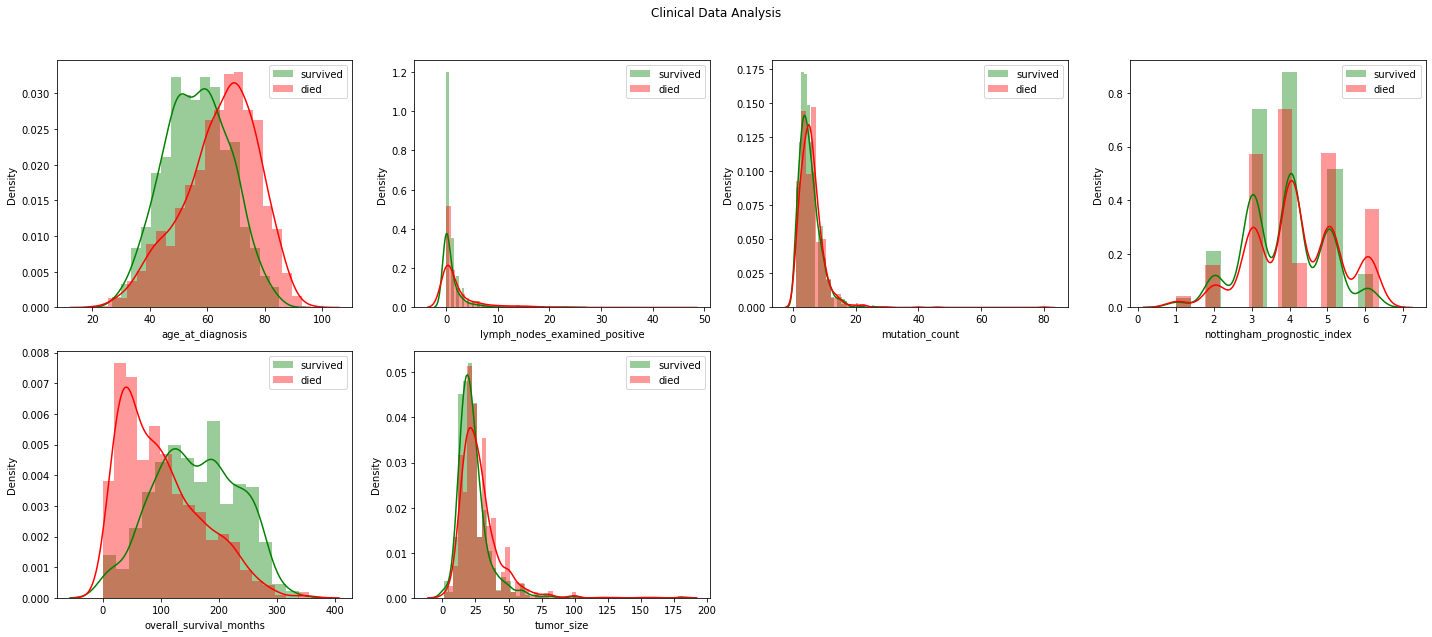

In [184]:
fig = plt.figure(figsize = (20, 25))
j = 0
num_clinical_columns= ['age_at_diagnosis', 'lymph_nodes_examined_positive','mutation_count','nottingham_prognostic_index', 'overall_survival_months', 'tumor_size']
for i in clinical_columns[num_clinical_columns].columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(clinical_columns[i][clinical_columns['overall_survival']==1], color='g', label = 'survived')
    sns.distplot(clinical_columns[i][clinical_columns['overall_survival']==0], color='r', label = 'died')
    plt.legend(loc='best')
fig.suptitle('Clinical Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [185]:
died = clinical_columns[clinical_columns['overall_survival']==0]
survived = clinical_columns[clinical_columns['overall_survival']==1]

alive = clinical_columns[clinical_columns['death_from_cancer']=='Living']
died_cancer = clinical_columns[clinical_columns['death_from_cancer']=='Died of Disease']
died_not_cancer = clinical_columns[clinical_columns['death_from_cancer']=='Died of Other Causes']

two_colors = [ sns.color_palette("Spectral")[0], sns.color_palette("afmhot")[5]]

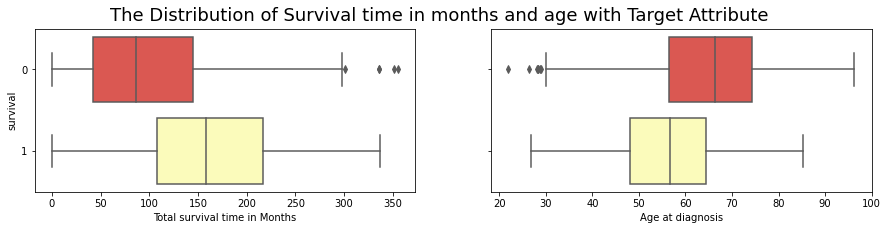

In [186]:
fig, ax = plt.subplots(ncols=2, figsize=(15,3), sharey=True)

sns.boxplot(x='overall_survival_months', y='overall_survival', orient='h', 
            data=clinical_columns, ax=ax[0], palette = two_colors, saturation=0.90)
sns.boxplot(x='age_at_diagnosis', y='overall_survival', orient='h',
            data=clinical_columns, ax=ax[1], palette = two_colors, saturation=0.90)

fig.suptitle('The Distribution of Survival time in months and age with Target Attribute', fontsize = 18)

ax[0].set_xlabel('Total survival time in Months')
ax[0].set_ylabel('survival')
ax[1].set_xlabel('Age at diagnosis')
ax[1].set_ylabel('')

plt.show()

#### Genetic mutation columns

In [187]:
mutation_features = df.columns[520:] 
mutation_columns = df[mutation_features]

In [188]:
mRna_columns.head()

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,bard1,mlh1,msh2,msh6,pms2,epcam,rad51c,rad51d,rad50,rb1,rbl1,rbl2,ccna1,ccnb1,cdk1,ccne1,cdk2,cdc25a,ccnd1,cdk4,cdk6,ccnd2,cdkn2a,cdkn2b,myc,cdkn1a,cdkn1b,e2f1,e2f2,...,hsd17b1,hsd17b10,hsd17b11,hsd17b12,hsd17b13,hsd17b14,hsd17b2,hsd17b3,hsd17b4,hsd17b6,hsd17b7,hsd17b8,hsd3b1,hsd3b2,hsd3b7,mecom,met,ncoa2,nrip1,pik3r3,prkci,prkd1,ran,rdh5,sdc4,serpini1,shbg,slc29a1,sox9,spry2,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,-0.8578,-0.4294,-1.1201,-0.4844,-0.7483,-1.6660,-0.1250,-0.3721,-0.6508,-0.1278,1.7330,-0.2770,-1.0673,0.0615,0.1034,-1.6635,-2.0649,-1.3388,-0.6208,-1.7309,-0.8059,-1.1037,0.0744,1.4313,-0.5785,1.2180,2.5602,2.3152,-0.2487,0.1601,-1.8799,...,0.2581,-0.0487,1.6822,1.7409,8.8731,-0.6494,0.4931,1.0860,0.2650,-1.8717,-1.7598,0.5445,0.5018,0.7345,-0.9899,1.1211,0.1674,-0.3421,0.4076,-0.6199,-1.2582,1.8407,0.6630,5.0109,0.5008,0.0052,-0.4357,0.9859,1.2386,2.8796,-1.1877,-0.0194,-1.6345,-0.2142,-0.5698,-1.1741,-1.4779,-0.5954,-0.8847,-0.3354
1,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,0.5120,0.4390,1.2266,0.7612,0.1821,1.0104,0.5600,-0.4018,-0.2909,0.7440,-1.7488,0.4602,0.7835,-0.2690,-0.2715,0.3895,-0.6273,0.1813,-1.2643,1.1057,0.4108,-0.6040,0.0546,0.2754,-0.0952,0.7248,0.4389,1.8759,-1.8984,-0.3327,...,-0.4467,-0.0693,-0.7837,0.0117,1.5355,0.7590,-0.5652,0.0623,-1.2693,1.0729,1.1973,-2.9847,-1.9199,0.6433,-0.4801,-1.8732,-1.0840,-0.7220,-0.1878,-1.0623,1.7653,0.3500,-0.2505,-0.6337,-0.1047,0.0222,-0.2938,-1.0821,-1.3206,0.2446,-0.4412,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-0.8920
2,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,0.2362,-0.1721,-1.7910,3.0955,0.6608,2.6127,2.5553,-0.0391,-0.4421,1.4528,1.4142,0.3143,-0.0662,-0.5558,0.6967,1.2949,-0.1245,-0.1109,-0.3923,-1.2747,-0.5312,0.2585,0.8958,-0.2270,1.1899,-0.7207,1.4829,3.0696,2.2248,-1.4859,...,-0.6253,0.0082,1.6822,0.8981,-0.0943,1.1599,0.1442,0.1493,0.1117,1.6262,2.2685,-0.9910,0.1767,-0.9128,-0.0006,0.7079,-0.7401,1.2279,-0.2882,-0.1727,1.1257,0.8306,0.2707,-0.7554,-0.3559,-0.7735,-0.1387,-0.9122,1.2552,0.4593,-0.5381,0.0668,0.8344,1.7227,0.4024,-3.7172,-1.5538,1.3701,-0.1078,0.3655
3,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,1.0078,-0.4010,-1.3905,4.8798,0.0615,2.9414,4.1161,-0.3098,-1.3470,1.2102,1.5345,-0.6347,0.7279,0.0219,1.8801,0.0476,-0.6651,-1.4457,-0.3827,-0.4537,-1.5248,0.3689,1.1455,0.0432,1.0868,-0.5237,0.2119,3.4617,0.4610,-1.5404,...,4.8189,0.0960,1.4099,-0.6707,-0.3589,-0.8998,-0.5063,0.2546,-0.6586,1.7024,0.1617,1.4208,0.1320,1.8754,-1.8850,0.1474,0.5097,-0.0393,-0.2049,-0.3290,3.2140,2.4162,1.7962,-1.2505,-0.1742,-0.2858,-0.7305,-1.0178,-0.7887,1.3361,-0.5630,-0.7078,0.8228,0.6819,-0.1948,-2.3286,-0.9924,-0.3154,0.2320,-0.4828
4,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,-0.2961,0.6320,-0.3582,0.3032,0.8747,0.6323,0.3349,-0.2652,-0.1541,-0.7631,1.0158,1.8996,0.6618,-0.7454,0.2862,1.1035,-1.0514,1.5423,1.2169,0.1169,1.7648,0.8892,-1.0195,0.3664,0.7145,0.5223,1.5638,0.1562,-0.2666,0.4509,...,-0.0590,0.2796,0.0493,-0.7074,0.0696,-0.4491,-0.5634,-0.7627,-0.7051,0.6065,-0.0141,0.7040,-2.0938,-0.1260,-0.6658,0.6451,0.5497,4.1999,0.2832,0.4018,0.1308,-0.5351,1.2930,1.2971,-0.8885,-0.5545,0.0266,0.5328,0.1858,-0.3201,-0.5845,-0.3544,-1.0150,2.2961,0.1817,-0.1572,0.0427,5.0048,3.8476,1.3223


#### Preprocessing

Para poder utilizar el AutoEncoder requerimos tener nuestras columnas en datos numéricos. Por lo tanto, vamos a realizar el preprocesamiento necesario para cada tipo de característica en el dataset. 

Las columnas de mutation genética ya se encuentran estandarizadas, así que no las transformaremos. Sólo es necesario revisar nulos y tratarlos. 

In [189]:
# En el caso de las columnas sobre mutationes en genes no tenemos datos nulos.
null_col = mRna_columns.isnull().mean()
null_col[null_col > 0]

Series([], dtype: float64)



---



---



##### Clinical Features

In [190]:
clinical_columns.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,hormone_therapy,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,1,Negative,1,ER-/HER2-,22.0,2.0,Living
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,1,Positive,1,ER+/HER2- High Prolif,10.0,1.0,Living
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Ductal/NST,1,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,0,Positive,0,NaN,15.0,2.0,Died of Disease
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Mixed,1,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,1,Positive,1,NaN,25.0,2.0,Living
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Mixed,1,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,0,Positive,1,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


De las variables clínicas tenemos columnas categóricas que hay que transformar. Revisamos su comportamiento y las modificamos

In [191]:
# Obtenemos las columnas sólo categóricas
clinical_cat_col = clinical_columns.select_dtypes(include='O')
clinical_cat_col.head()

,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,pam50_+_claudin-low_subtype,er_status_measured_by_ihc,er_status,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,oncotree_code,pr_status,3-gene_classifier_subtype,death_from_cancer
0,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,claudin-low,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Post,4ER+,Right,IDC,Negative,ER-/HER2-,Living
1,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumA,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Pre,4ER+,Right,IDC,Positive,ER+/HER2- High Prolif,Living
2,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumB,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Pre,3,Right,IDC,Positive,NaN,Died of Disease
3,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,LumB,Positve,Positive,NEUTRAL,Negative,Mixed,Pre,9,Right,MDLC,Positive,NaN,Living
4,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,LumB,Positve,Positive,NEUTRAL,Negative,Mixed,Post,9,Right,MDLC,Positive,ER+/HER2- High Prolif,Died of Disease


In [192]:
# Imprimimos las categorías únicas y la cantidad de valores nulos
for col in clinical_cat_col.columns:
  print(f'Unique Categories for {col}:', clinical_cat_col[col].unique())
  print('NaN Values:', clinical_cat_col[col].isna().sum())
  print()

Unique Categories for type_of_breast_surgery: ['MASTECTOMY' 'BREAST CONSERVING' nan]
NaN Values: 22

Unique Categories for cancer_type: ['Breast Cancer' 'Breast Sarcoma']
NaN Values: 0

Unique Categories for cancer_type_detailed: ['Breast Invasive Ductal Carcinoma'
 'Breast Mixed Ductal and Lobular Carcinoma'
 'Breast Invasive Lobular Carcinoma'
 'Breast Invasive Mixed Mucinous Carcinoma' 'Breast' nan
 'Metaplastic Breast Cancer']
NaN Values: 15

Unique Categories for cellularity: [nan 'High' 'Moderate' 'Low']
NaN Values: 54

Unique Categories for pam50_+_claudin-low_subtype: ['claudin-low' 'LumA' 'LumB' 'Her2' 'Normal' 'Basal' 'NC']
NaN Values: 0

Unique Categories for er_status_measured_by_ihc: ['Positve' 'Negative' nan]
NaN Values: 30

Unique Categories for er_status: ['Positive' 'Negative']
NaN Values: 0

Unique Categories for her2_status_measured_by_snp6: ['NEUTRAL' 'LOSS' 'GAIN' 'UNDEF']
NaN Values: 0

Unique Categories for her2_status: ['Negative' 'Positive']
NaN Values: 0

Uniq

In [193]:
# Esta columna sólo tiene un registro nulos que guardaremos para quitarlo 
# más tarde.
to_drop = clinical_cat_col[clinical_cat_col['death_from_cancer'].isnull()].index
to_drop

Int64Index([1166], dtype='int64')

In [194]:
# Cantidad de registros que tenemos
clinical_cat_col.shape

(1904, 17)

In [195]:
# Con cuantos registros nos quedaríamos si tenemos valores nulos.
clinical_cat_col.dropna().shape

(1519, 17)

In [196]:

null_cat = clinical_cat_col.isnull().sum()
name_null_cat = null_cat[null_cat > 1].index
name_null_cat

Index(['type_of_breast_surgery', 'cancer_type_detailed', 'cellularity',
       'er_status_measured_by_ihc', 'tumor_other_histologic_subtype',
       'primary_tumor_laterality', 'oncotree_code',
       '3-gene_classifier_subtype'],
      dtype='object')

type_of_breast_surgery


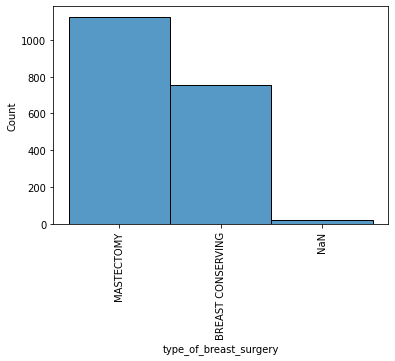

cancer_type_detailed


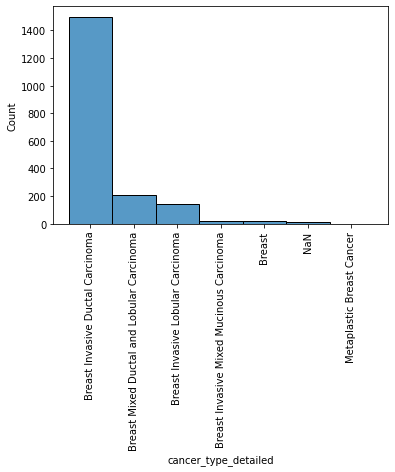

cellularity


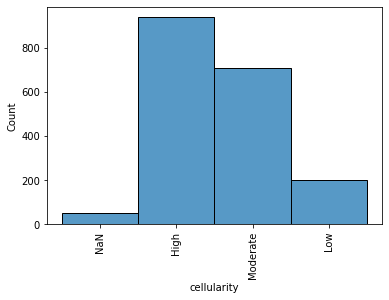

er_status_measured_by_ihc


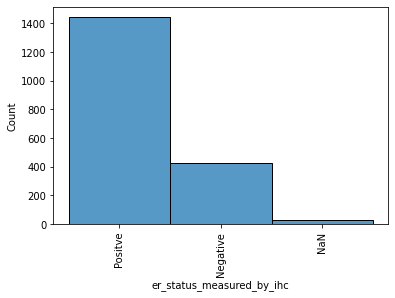

tumor_other_histologic_subtype


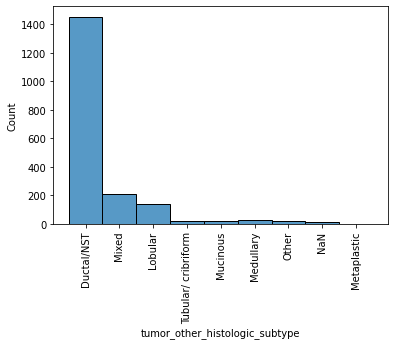

primary_tumor_laterality


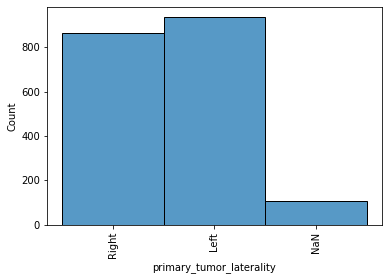

oncotree_code


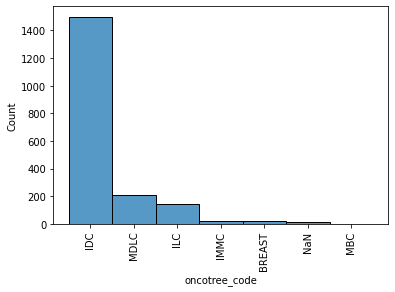

3-gene_classifier_subtype


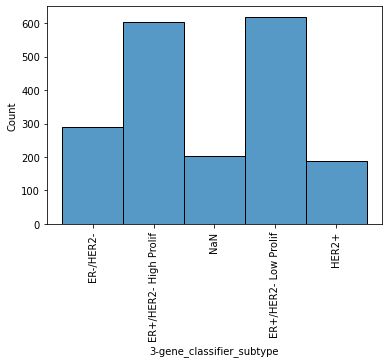

In [197]:
for col in name_null_cat:
  print(col)
  sns.histplot(clinical_cat_col[col].fillna('NaN'))
  plt.xticks(rotation=90)
  plt.show();

In [198]:
reg_to_drop = list()
for col in name_null_cat:
  null_count = clinical_cat_col[col].isnull().sum()
  if null_count < 50: 
    reg_to_drop += clinical_cat_col[clinical_cat_col[col].isnull()].index.tolist()
  else:
    clinical_cat_col.loc[clinical_cat_col[col].isnull(), col] = stats.mode(clinical_cat_col[col])[0]

In [199]:
print(reg_to_drop)

[36, 152, 160, 166, 170, 171, 189, 204, 218, 224, 357, 375, 417, 457, 463, 476, 799, 1000, 1047, 1164, 1169, 1195, 206, 210, 352, 357, 1194, 1205, 1316, 1325, 1341, 1441, 1698, 1723, 1747, 1782, 1857, 131, 132, 134, 141, 157, 159, 170, 208, 476, 498, 841, 946, 980, 994, 1010, 1032, 1033, 1035, 1036, 1070, 1183, 1192, 1241, 1773, 1775, 1779, 1780, 1791, 1792, 1819, 206, 210, 352, 357, 1194, 1205, 1316, 1325, 1341, 1441, 1698, 1723, 1747, 1782, 1857, 206, 210, 352, 357, 1194, 1205, 1316, 1325, 1341, 1441, 1698, 1723, 1747, 1782, 1857]


In [200]:
len(reg_to_drop)

97

In [201]:
clinical_cat_col['cellularity'].isnull().sum()

0

In [202]:
reg_to_drop = reg_to_drop + to_drop.tolist()
len(reg_to_drop)

98

In [203]:
clinical_cat_clean = clinical_cat_col.drop(index=reg_to_drop)
clinical_cat_clean.shape

(1839, 17)

In [204]:
cat_1, cat_2 = clinical_cat_clean['type_of_breast_surgery'].unique()

In [205]:
cat_1, cat_2

('MASTECTOMY', 'BREAST CONSERVING')

In [206]:
dummies = list()

for col in clinical_cat_clean.columns:
  if clinical_cat_clean[col].unique().shape[0] == 2:
    cat_1, cat_2 = clinical_cat_clean[col].unique()
    clinical_cat_clean[col] = clinical_cat_clean[col].apply(lambda x: 1 if x == cat_1 else 0)
  else:
    dummies.append(pd.get_dummies(clinical_cat_clean[col]))

In [207]:
df_dummies = pd.concat(dummies, axis=1)

In [208]:
df_dummies.head()

,Breast Cancer,Breast,Breast Invasive Ductal Carcinoma,Breast Invasive Lobular Carcinoma,Breast Invasive Mixed Mucinous Carcinoma,Breast Mixed Ductal and Lobular Carcinoma,Metaplastic Breast Cancer,High,Low,Moderate,Basal,Her2,LumA,LumB,NC,Normal,claudin-low,GAIN,LOSS,NEUTRAL,UNDEF,Ductal/NST,Lobular,Medullary,Metaplastic,Mixed,Mucinous,Other,Tubular/ cribriform,1,10,2,3,4ER+,4ER-,5,6,7,8,9,BREAST,IDC,ILC,IMMC,MBC,MDLC,ER+/HER2- High Prolif,ER+/HER2- Low Prolif,ER-/HER2-,HER2+,Died of Disease,Died of Other Causes,Living
0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
2,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
3,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1
4,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0


In [209]:
clinical_cat_clean.head()

,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,pam50_+_claudin-low_subtype,er_status_measured_by_ihc,er_status,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,oncotree_code,pr_status,3-gene_classifier_subtype,death_from_cancer
0,1,Breast Cancer,Breast Invasive Ductal Carcinoma,High,claudin-low,1,1,NEUTRAL,1,Ductal/NST,1,4ER+,1,IDC,1,ER-/HER2-,Living
1,0,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumA,1,1,NEUTRAL,1,Ductal/NST,0,4ER+,1,IDC,0,ER+/HER2- High Prolif,Living
2,1,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumB,1,1,NEUTRAL,1,Ductal/NST,0,3,1,IDC,0,ER+/HER2- Low Prolif,Died of Disease
3,1,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,LumB,1,1,NEUTRAL,1,Mixed,0,9,1,MDLC,0,ER+/HER2- Low Prolif,Living
4,1,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,LumB,1,1,NEUTRAL,1,Mixed,1,9,1,MDLC,0,ER+/HER2- High Prolif,Died of Disease


In [210]:
clinical_cat_clean.shape

(1839, 17)

In [211]:
clinical_to_num = pd.concat([clinical_cat_clean, df_dummies], axis=1)._get_numeric_data()
clinical_to_num.head()

,type_of_breast_surgery,er_status_measured_by_ihc,er_status,her2_status,inferred_menopausal_state,primary_tumor_laterality,pr_status,Breast Cancer,Breast,Breast Invasive Ductal Carcinoma,Breast Invasive Lobular Carcinoma,Breast Invasive Mixed Mucinous Carcinoma,Breast Mixed Ductal and Lobular Carcinoma,Metaplastic Breast Cancer,High,Low,Moderate,Basal,Her2,LumA,LumB,NC,Normal,claudin-low,GAIN,LOSS,NEUTRAL,UNDEF,Ductal/NST,Lobular,Medullary,Metaplastic,Mixed,Mucinous,Other,Tubular/ cribriform,1,10,2,3,4ER+,4ER-,5,6,7,8,9,BREAST,IDC,ILC,IMMC,MBC,MDLC,ER+/HER2- High Prolif,ER+/HER2- Low Prolif,ER-/HER2-,HER2+,Died of Disease,Died of Other Causes,Living
0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
1,0,1,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
2,1,1,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
3,1,1,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1
4,1,1,1,1,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0


In [212]:
clinical_to_num.shape

(1839, 60)

In [213]:
clinical_num_col = clinical_columns._get_numeric_data()
clinical_num_col.head()

,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,tumor_size,tumor_stage
0,0,75.65,0,1.0,3.0,1,10.0,NaN,6.044,140.500000,1,1,22.0,2.0
1,2,43.19,0,1.0,3.0,1,0.0,2.0,4.020,84.633333,1,1,10.0,1.0
2,5,48.87,1,1.0,2.0,1,1.0,2.0,4.030,163.700000,0,0,15.0,2.0
3,6,47.68,1,1.0,2.0,1,3.0,1.0,4.050,164.933333,1,1,25.0,2.0
4,8,76.97,1,1.0,3.0,1,8.0,2.0,6.080,41.366667,0,1,40.0,2.0


In [214]:
clinical_num_col.shape

(1904, 14)

In [215]:
clinical_num_col.isnull().sum()

patient_id                         0
age_at_diagnosis                   0
chemotherapy                       0
cohort                             0
neoplasm_histologic_grade         72
hormone_therapy                    0
lymph_nodes_examined_positive      0
mutation_count                    45
nottingham_prognostic_index        0
overall_survival_months            0
overall_survival                   0
radio_therapy                      0
tumor_size                        20
tumor_stage                      501
dtype: int64

In [216]:
clinical_num_col.drop(columns='tumor_stage', inplace=True)

In [217]:
clinical_num_col.dropna(inplace=True)
clinical_num_col.shape

(1770, 13)

In [218]:
clinical_clean = pd.concat([clinical_num_col, clinical_to_num], axis=1)
clinical_clean.shape

(1890, 73)

In [219]:
clinical_clean.dropna(inplace=True)
clinical_clean.shape

(1719, 73)

##### Mutations Features

In [221]:
for col in mutation_columns.columns:
  mutation_columns[col] = mutation_columns[col].apply(lambda x: 0 if x == '0' else 1)

In [63]:
mutation_columns.head()

,pik3ca_mut,tp53_mut,muc16_mut,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,dnah11_mut,cdh1_mut,dnah2_mut,kmt2d_mut,ush2a_mut,ryr2_mut,dnah5_mut,herc2_mut,pde4dip_mut,akap9_mut,tg_mut,birc6_mut,utrn_mut,tbx3_mut,col6a3_mut,arid1a_mut,lama2_mut,notch1_mut,cbfb_mut,ncor2_mut,col12a1_mut,col22a1_mut,pten_mut,akt1_mut,atr_mut,thada_mut,ncor1_mut,stab2_mut,myh9_mut,runx1_mut,nf1_mut,...,gpr32_mut,kras_mut,nf2_mut,chek2_mut,ldlrap1_mut,clrn2_mut,acvrl1_mut,agtr2_mut,cdkn2a_mut,ctnna1_mut,magea8_mut,prr16_mut,dtwd2_mut,akt2_mut,braf_mut,foxo1_mut,nt5e_mut,ccnd3_mut,nr3c1_mut,prkg1_mut,tbl1xr1_mut,frmd3_mut,smad2_mut,sgcd_mut,spaca1_mut,rasgef1b_mut,hist1h2bc_mut,nr2f1_mut,klrg1_mut,mbl2_mut,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1


#### DF to use

In [64]:
df_transform = pd.concat([mutation_columns, clinical_clean, mRna_columns], axis=1)
df_transform = df_transform.dropna()
df_transform.shape

(1719, 735)

In [65]:
df_transform.head()

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,bard1,mlh1,msh2,msh6,pms2,epcam,rad51c,rad51d,rad50,rb1,rbl1,rbl2,ccna1,ccnb1,cdk1,ccne1,cdk2,cdc25a,ccnd1,cdk4,cdk6,ccnd2,cdkn2a,cdkn2b,myc,cdkn1a,cdkn1b,e2f1,e2f2,...,gpr32_mut,kras_mut,nf2_mut,chek2_mut,ldlrap1_mut,clrn2_mut,acvrl1_mut,agtr2_mut,cdkn2a_mut,ctnna1_mut,magea8_mut,prr16_mut,dtwd2_mut,akt2_mut,braf_mut,foxo1_mut,nt5e_mut,ccnd3_mut,nr3c1_mut,prkg1_mut,tbl1xr1_mut,frmd3_mut,smad2_mut,sgcd_mut,spaca1_mut,rasgef1b_mut,hist1h2bc_mut,nr2f1_mut,klrg1_mut,mbl2_mut,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
1,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,0.5120,0.4390,1.2266,0.7612,0.1821,1.0104,0.5600,-0.4018,-0.2909,0.7440,-1.7488,0.4602,0.7835,-0.2690,-0.2715,0.3895,-0.6273,0.1813,-1.2643,1.1057,0.4108,-0.6040,0.0546,0.2754,-0.0952,0.7248,0.4389,1.8759,-1.8984,-0.3327,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1
2,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,0.2362,-0.1721,-1.7910,3.0955,0.6608,2.6127,2.5553,-0.0391,-0.4421,1.4528,1.4142,0.3143,-0.0662,-0.5558,0.6967,1.2949,-0.1245,-0.1109,-0.3923,-1.2747,-0.5312,0.2585,0.8958,-0.2270,1.1899,-0.7207,1.4829,3.0696,2.2248,-1.4859,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1
3,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,1.0078,-0.4010,-1.3905,4.8798,0.0615,2.9414,4.1161,-0.3098,-1.3470,1.2102,1.5345,-0.6347,0.7279,0.0219,1.8801,0.0476,-0.6651,-1.4457,-0.3827,-0.4537,-1.5248,0.3689,1.1455,0.0432,1.0868,-0.5237,0.2119,3.4617,0.4610,-1.5404,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1
4,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,-0.2961,0.6320,-0.3582,0.3032,0.8747,0.6323,0.3349,-0.2652,-0.1541,-0.7631,1.0158,1.8996,0.6618,-0.7454,0.2862,1.1035,-1.0514,1.5423,1.2169,0.1169,1.7648,0.8892,-1.0195,0.3664,0.7145,0.5223,1.5638,0.1562,-0.2666,0.4509,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1
5,-0.4341,0.6931,0.6909,1.0840,-1.9371,0.9252,1.1520,0.7951,-0.9677,-0.7750,-0.3532,1.0599,-0.2754,0.5496,1.1321,-0.4786,0.3220,0.2841,-0.3295,-0.0611,0.8727,0.8561,0.5396,-0.0412,1.5735,1.5887,-0.4022,0.9184,0.4784,-0.8358,1.1628,-0.2269,-0.7485,-0.4693,-0.1114,-0.8320,-0.8937,0.3760,1.4738,1.0299,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1


#### Divide Data

In [87]:
X = df_transform.drop(columns=['patient_id', 'Died of Disease', 'Died of Other Causes', 'Living', 'overall_survival'])
y = df_transform['overall_survival']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

### Keras

Keras es un API de alto nivle que implementa deep learning. Por detrás usa Tensorflow. La idea general de Keras es poder implementar de forma simple, flexible y potente procesos de aprendizaje profundo. A diferencia de Tensorflow que es explícito y la sintaxis es poco amigable.  

* Utiliza tensores.
* Utiliza CPU, GPU, TPU. 
* Computa el gradiente de expresiones diferenciales.

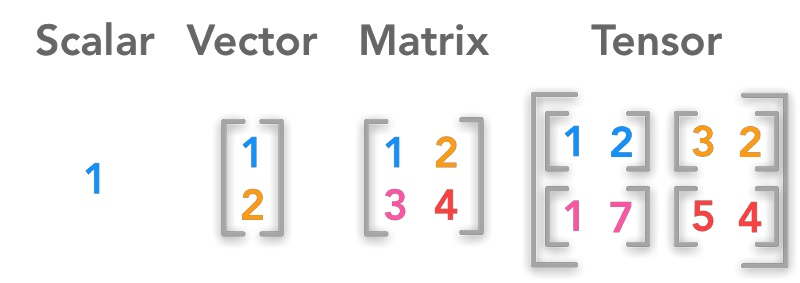

https://www.tensorflow.org/guide/tensor

*Un pequeño ejemplo*

In [67]:
# La estructura básica para crear un modelo es la clase Sequencial
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.datasets import mnist

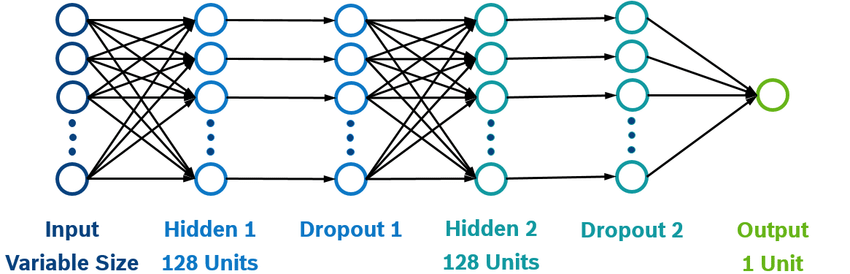

In [68]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11501568/11490434 [==============================] - 0s 0us/step


In [69]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [70]:
# Inicializamos el modelo
# Añadimos capas densas de redes neuronales con cierta función de activación
model = Sequential([
  Flatten(input_shape=(28, 28)),
  Dense(128, activation='relu'),
  Dropout(0.2),
  Dense(10, activation='softmax')
])

In [71]:
# Configuramos el proceso de aprendizaje
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [72]:
#Ajustamos nuestros datos a la muestra 
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2919 - accuracy: 0.9150
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1448 - accuracy: 0.9575
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1074 - accuracy: 0.9679
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0871 - accuracy: 0.9740
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0743 - accuracy: 0.9764


In [73]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.0735 - accuracy: 0.9792


[0.07353644073009491, 0.979200005531311]

### Simple Autoencoder

In [88]:
n_features = X.shape[1]
n_features

730

In [89]:
encoding_dim = 40

In [90]:
input = layers.Input(shape=(n_features, ))

In [91]:
encoded = layers.Dense(encoding_dim, activation='sigmoid')(input)

In [92]:
decoded = layers.Dense(n_features, activation='sigmoid')(encoded)

In [93]:
# maps an input to its reconstruction
autoencoder = Model(inputs=input, outputs=decoded)

In [94]:
encoder = Model(input, encoded)

In [95]:
autoencoder.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=0.01))

In [107]:
history = autoencoder.fit(X_train, X_train, epochs=200, batch_size=32, 
                          shuffle=True, verbose=1, validation_data=(X_test, X_test))

Epoch 1/200
43/43 [==============================] - 0s 10ms/step - loss: 36.4532 - val_loss: 35.5751
Epoch 2/200
43/43 [==============================] - 0s 3ms/step - loss: 36.4530 - val_loss: 35.5750
Epoch 3/200
43/43 [==============================] - 0s 3ms/step - loss: 36.4529 - val_loss: 35.5748
Epoch 4/200
43/43 [==============================] - 0s 3ms/step - loss: 36.4527 - val_loss: 35.5747
Epoch 5/200
43/43 [==============================] - 0s 2ms/step - loss: 36.4525 - val_loss: 35.5745
Epoch 6/200
43/43 [==============================] - 0s 3ms/step - loss: 36.4524 - val_loss: 35.5743
Epoch 7/200
43/43 [==============================] - 0s 3ms/step - loss: 36.4522 - val_loss: 35.5742
Epoch 8/200
43/43 [==============================] - 0s 3ms/step - loss: 36.4521 - val_loss: 35.5740
Epoch 9/200
43/43 [==============================] - 0s 3ms/step - loss: 36.4519 - val_loss: 35.5739
Epoch 10/200
43/43 [==============================] - 0s 3ms/step - loss: 36.4518 - val_lo

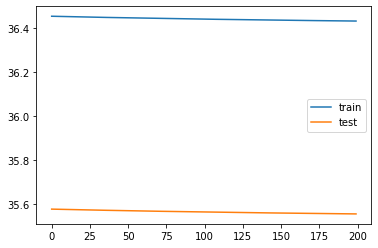

In [108]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

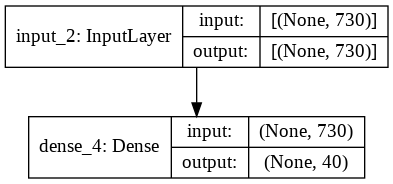

In [97]:
plot_model(encoder, show_shapes=True)

In [98]:
X_train_encode = encoder.predict(X_train)
X_test_encode = encoder.predict(X_test)

In [99]:
X_train_encode

array([[9.99992013e-01, 9.99920845e-01, 9.99966741e-01, ...,
        9.99999762e-01, 1.14108622e-02, 9.99970675e-01],
       [1.00000000e+00, 9.99999523e-01, 1.00000000e+00, ...,
        1.00000000e+00, 2.08974852e-05, 1.00000000e+00],
       [9.99999642e-01, 9.99991894e-01, 9.99999642e-01, ...,
        1.00000000e+00, 1.66687369e-03, 1.00000000e+00],
       ...,
       [9.99998808e-01, 9.99980092e-01, 9.99999166e-01, ...,
        1.00000000e+00, 1.28552318e-03, 9.99999881e-01],
       [1.00000000e+00, 9.99999225e-01, 1.00000000e+00, ...,
        1.00000000e+00, 1.23540685e-05, 1.00000000e+00],
       [9.99989271e-01, 9.99923289e-01, 9.99891400e-01, ...,
        9.99998212e-01, 2.90322304e-03, 9.99996066e-01]], dtype=float32)

### AdaBoost Classifier

In [100]:
clf = AdaBoostClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=42)

In [101]:
y_pred_train = clf.predict(X_train)

In [102]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       804
         1.0       0.94      0.92      0.93       571

    accuracy                           0.94      1375
   macro avg       0.94      0.94      0.94      1375
weighted avg       0.94      0.94      0.94      1375



In [103]:
y_pred_test = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.75      0.79      0.77       193
         1.0       0.71      0.67      0.69       151

    accuracy                           0.74       344
   macro avg       0.73      0.73      0.73       344
weighted avg       0.73      0.74      0.73       344



#### Classification with Encoder

In [109]:
clf = AdaBoostClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_encode, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=42)

In [110]:
y_pred_train = clf.predict(X_train_encode)

In [111]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.85      0.82      0.84       804
         1.0       0.76      0.80      0.78       571

    accuracy                           0.81      1375
   macro avg       0.81      0.81      0.81      1375
weighted avg       0.81      0.81      0.81      1375



In [112]:
y_pred_test = clf.predict(X_test_encode)

In [113]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.75      0.76      0.75       193
         1.0       0.68      0.68      0.68       151

    accuracy                           0.72       344
   macro avg       0.72      0.72      0.72       344
weighted avg       0.72      0.72      0.72       344



### Autoencoder 

In [114]:
n_features = X.shape[1]
encoding_dim = 40
input = layers.Input(shape=(n_features, ))

In [115]:
encoded = layers.Dense(365, activation='sigmoid')(input)
encoded = layers.Dense(73, activation='sigmoid')(encoded)
encoded = layers.Dense(40, activation='sigmoid')(encoded)

In [116]:
decoded = layers.Dense(40, activation='sigmoid')(encoded)
decoded = layers.Dense(73, activation='sigmoid')(decoded)
decoded = layers.Dense(n_features, activation='sigmoid')(decoded)

In [117]:
# maps an input to its reconstruction
autoencoder = Model(inputs=input, outputs=decoded)

In [118]:
encoder = Model(input, encoded)

In [121]:
autoencoder.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=0.1))

In [123]:
history = autoencoder.fit(X_train, X_train, epochs=200, batch_size=32, shuffle=True,
                verbose=1, validation_data=(X_test, X_test))

Epoch 1/200
43/43 [==============================] - 0s 6ms/step - loss: 36.4340 - val_loss: 35.5553
Epoch 2/200
43/43 [==============================] - 0s 5ms/step - loss: 36.4327 - val_loss: 35.5540
Epoch 3/200
43/43 [==============================] - 0s 5ms/step - loss: 36.4315 - val_loss: 35.5528
Epoch 4/200
43/43 [==============================] - 0s 5ms/step - loss: 36.4303 - val_loss: 35.5517
Epoch 5/200
43/43 [==============================] - 0s 5ms/step - loss: 36.4292 - val_loss: 35.5506
Epoch 6/200
43/43 [==============================] - 0s 6ms/step - loss: 36.4281 - val_loss: 35.5496
Epoch 7/200
43/43 [==============================] - 0s 5ms/step - loss: 36.4271 - val_loss: 35.5486
Epoch 8/200
43/43 [==============================] - 0s 5ms/step - loss: 36.4262 - val_loss: 35.5477
Epoch 9/200
43/43 [==============================] - 0s 6ms/step - loss: 36.4253 - val_loss: 35.5468
Epoch 10/200
43/43 [==============================] - 0s 5ms/step - loss: 36.4244 - val_los

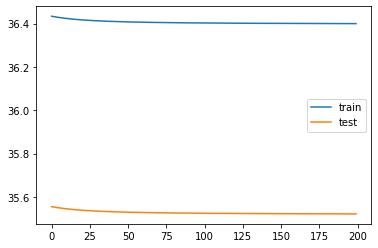

In [124]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

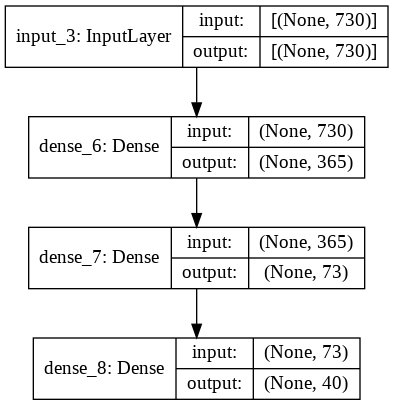

In [125]:
plot_model(encoder, show_shapes=True)

In [126]:
X_train_encode = encoder.predict(X_train)
X_test_encode = encoder.predict(X_test)

In [127]:
X_train_encode.shape, X_test_encode.shape

((1375, 40), (344, 40))

### AdaBoost Multiple Layers

In [128]:
clf = AdaBoostClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_encode, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=42)

In [129]:
y_pred_train = clf.predict(X_train_encode)

In [130]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86       804
         1.0       0.80      0.81      0.80       571

    accuracy                           0.84      1375
   macro avg       0.83      0.83      0.83      1375
weighted avg       0.84      0.84      0.84      1375



In [131]:
y_pred_test = clf.predict(X_test_encode)

In [132]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74       193
         1.0       0.67      0.61      0.64       151

    accuracy                           0.70       344
   macro avg       0.69      0.69      0.69       344
weighted avg       0.70      0.70      0.70       344



### Autoencoder 2.0

In [133]:
n_features = X.shape[1]
encoding_dim = 200
input = layers.Input(shape=(n_features, ))

In [134]:
encoded = layers.Dense(n_features, activation='sigmoid')(input)
encoded = layers.Dense(400, activation='sigmoid')(encoded)
encoded = layers.Dense(200, activation='sigmoid')(encoded)

In [135]:
decoded = layers.Dense(200, activation='sigmoid')(encoded)
decoded = layers.Dense(400, activation='sigmoid')(decoded)
decoded = layers.Dense(n_features, activation='sigmoid')(decoded)

In [136]:
# maps an input to its reconstruction
autoencoder = Model(inputs=input, outputs=decoded)

In [137]:
encoder = Model(input, encoded)

In [138]:
autoencoder.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=0.1), metrics=['accuracy'])

In [139]:
history = autoencoder.fit(X_train, X_train, epochs=200, batch_size=32, shuffle=True,
                verbose=1, validation_data=(X_test, X_test))

Epoch 1/200
43/43 [==============================] - 1s 22ms/step - loss: 36.6724 - accuracy: 0.7098 - val_loss: 35.7436 - val_accuracy: 0.7297
Epoch 2/200
43/43 [==============================] - 1s 15ms/step - loss: 36.6034 - accuracy: 0.7433 - val_loss: 35.7075 - val_accuracy: 0.7297
Epoch 3/200
43/43 [==============================] - 1s 15ms/step - loss: 36.5715 - accuracy: 0.7433 - val_loss: 35.6792 - val_accuracy: 0.7297
Epoch 4/200
43/43 [==============================] - 1s 15ms/step - loss: 36.5456 - accuracy: 0.7433 - val_loss: 35.6557 - val_accuracy: 0.7297
Epoch 5/200
43/43 [==============================] - 1s 15ms/step - loss: 36.5239 - accuracy: 0.7433 - val_loss: 35.6359 - val_accuracy: 0.7297
Epoch 6/200
43/43 [==============================] - 1s 14ms/step - loss: 36.5056 - accuracy: 0.7433 - val_loss: 35.6193 - val_accuracy: 0.7297
Epoch 7/200
43/43 [==============================] - 1s 14ms/step - loss: 36.4904 - accuracy: 0.7433 - val_loss: 35.6055 - val_accuracy:

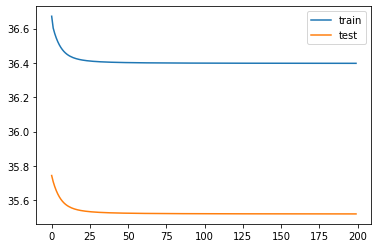

In [140]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

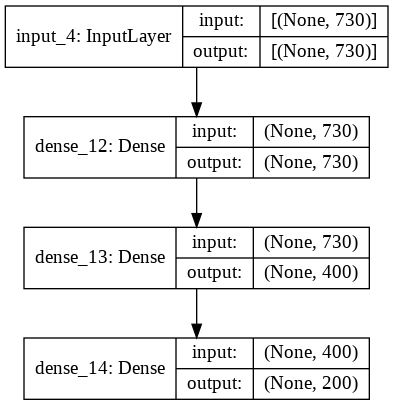

In [141]:
plot_model(encoder, show_shapes=True)

In [142]:
X_train_encode = encoder.predict(X_train)
X_test_encode = encoder.predict(X_test)

In [143]:
X_train_encode.shape, X_test_encode.shape

((1375, 200), (344, 200))

### AdaBoost Multiple Layers 2.0

In [154]:
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X_train_encode, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=None)

In [155]:
y_pred_train = clf.predict(X_train_encode)

In [156]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       804
         1.0       0.88      0.88      0.88       571

    accuracy                           0.90      1375
   macro avg       0.89      0.89      0.89      1375
weighted avg       0.90      0.90      0.90      1375



In [157]:
y_pred_test = clf.predict(X_test_encode)

In [158]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.75      0.78      0.77       193
         1.0       0.71      0.67      0.69       151

    accuracy                           0.73       344
   macro avg       0.73      0.73      0.73       344
weighted avg       0.73      0.73      0.73       344

